In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("customer_segmentation.csv")

In [4]:
df.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


### Customer Segmentation Using K-Means Clustering

In this guided project, we take on the role of a data scientist at a credit card company. Our task is to segment the company’s clients into distinct groups using unsupervised learning. This segmentation will enable the company to apply targeted business strategies for each group.

#### Project Objective

The goal is to identify meaningful customer segments based on their credit card usage and demographic characteristics. These segments can help the company:
- Offer higher credit limits to low-risk, high-usage customers.
- Create incentives for high-income customers who underutilize their credit lines.
- Design tailored marketing or loyalty strategies based on usage behavior.

In [6]:
df.shape

(10127, 14)

In [7]:
df.describe()

,customer_id,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,62078.206774,35.928409,3.812580,2.341167,8631.953698,4404.086304,64.858695,0.274894
std,3.690378e+07,8.016814,1.298908,39372.861291,7.986416,1.554408,1.010622,9088.776650,3397.129254,23.472570,0.275691
min,7.080821e+08,26.000000,0.000000,20000.000000,13.000000,1.000000,0.000000,1438.300000,510.000000,10.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,32000.000000,31.000000,3.000000,2.000000,2555.000000,2155.500000,45.000000,0.023000
50%,7.179264e+08,46.000000,2.000000,50000.000000,36.000000,4.000000,2.000000,4549.000000,3899.000000,67.000000,0.176000
75%,7.731435e+08,52.000000,3.000000,80000.000000,40.000000,5.000000,3.000000,11067.500000,4741.000000,81.000000,0.503000
max,8.283431e+08,73.000000,5.000000,200000.000000,56.000000,6.000000,6.000000,34516.000000,18484.000000,139.000000,0.999000


In [8]:
df.dtypes

customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object

In [9]:
df.isnull().sum()

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64

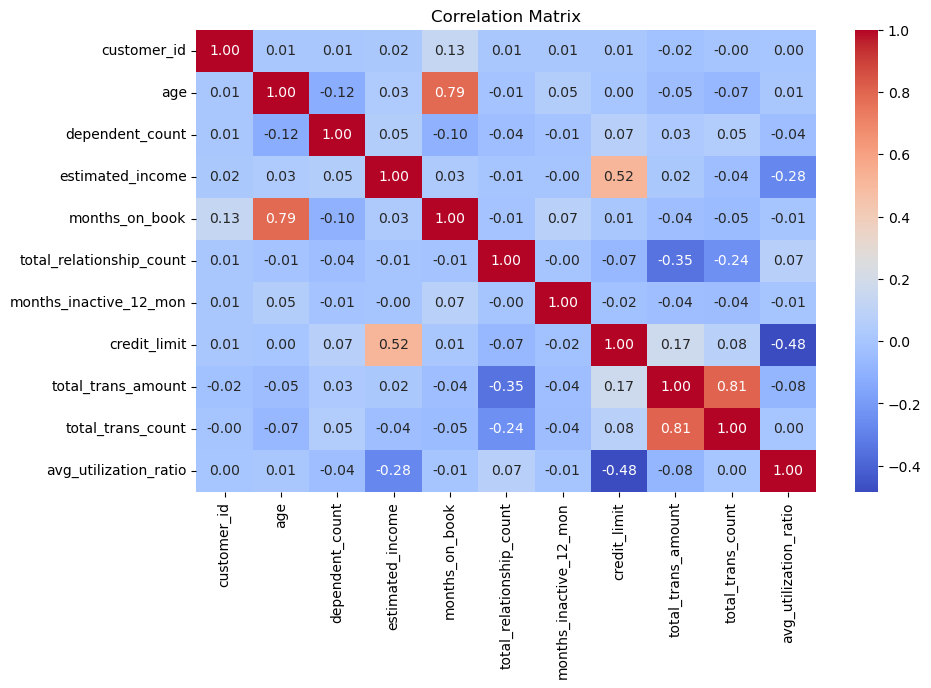

In [10]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

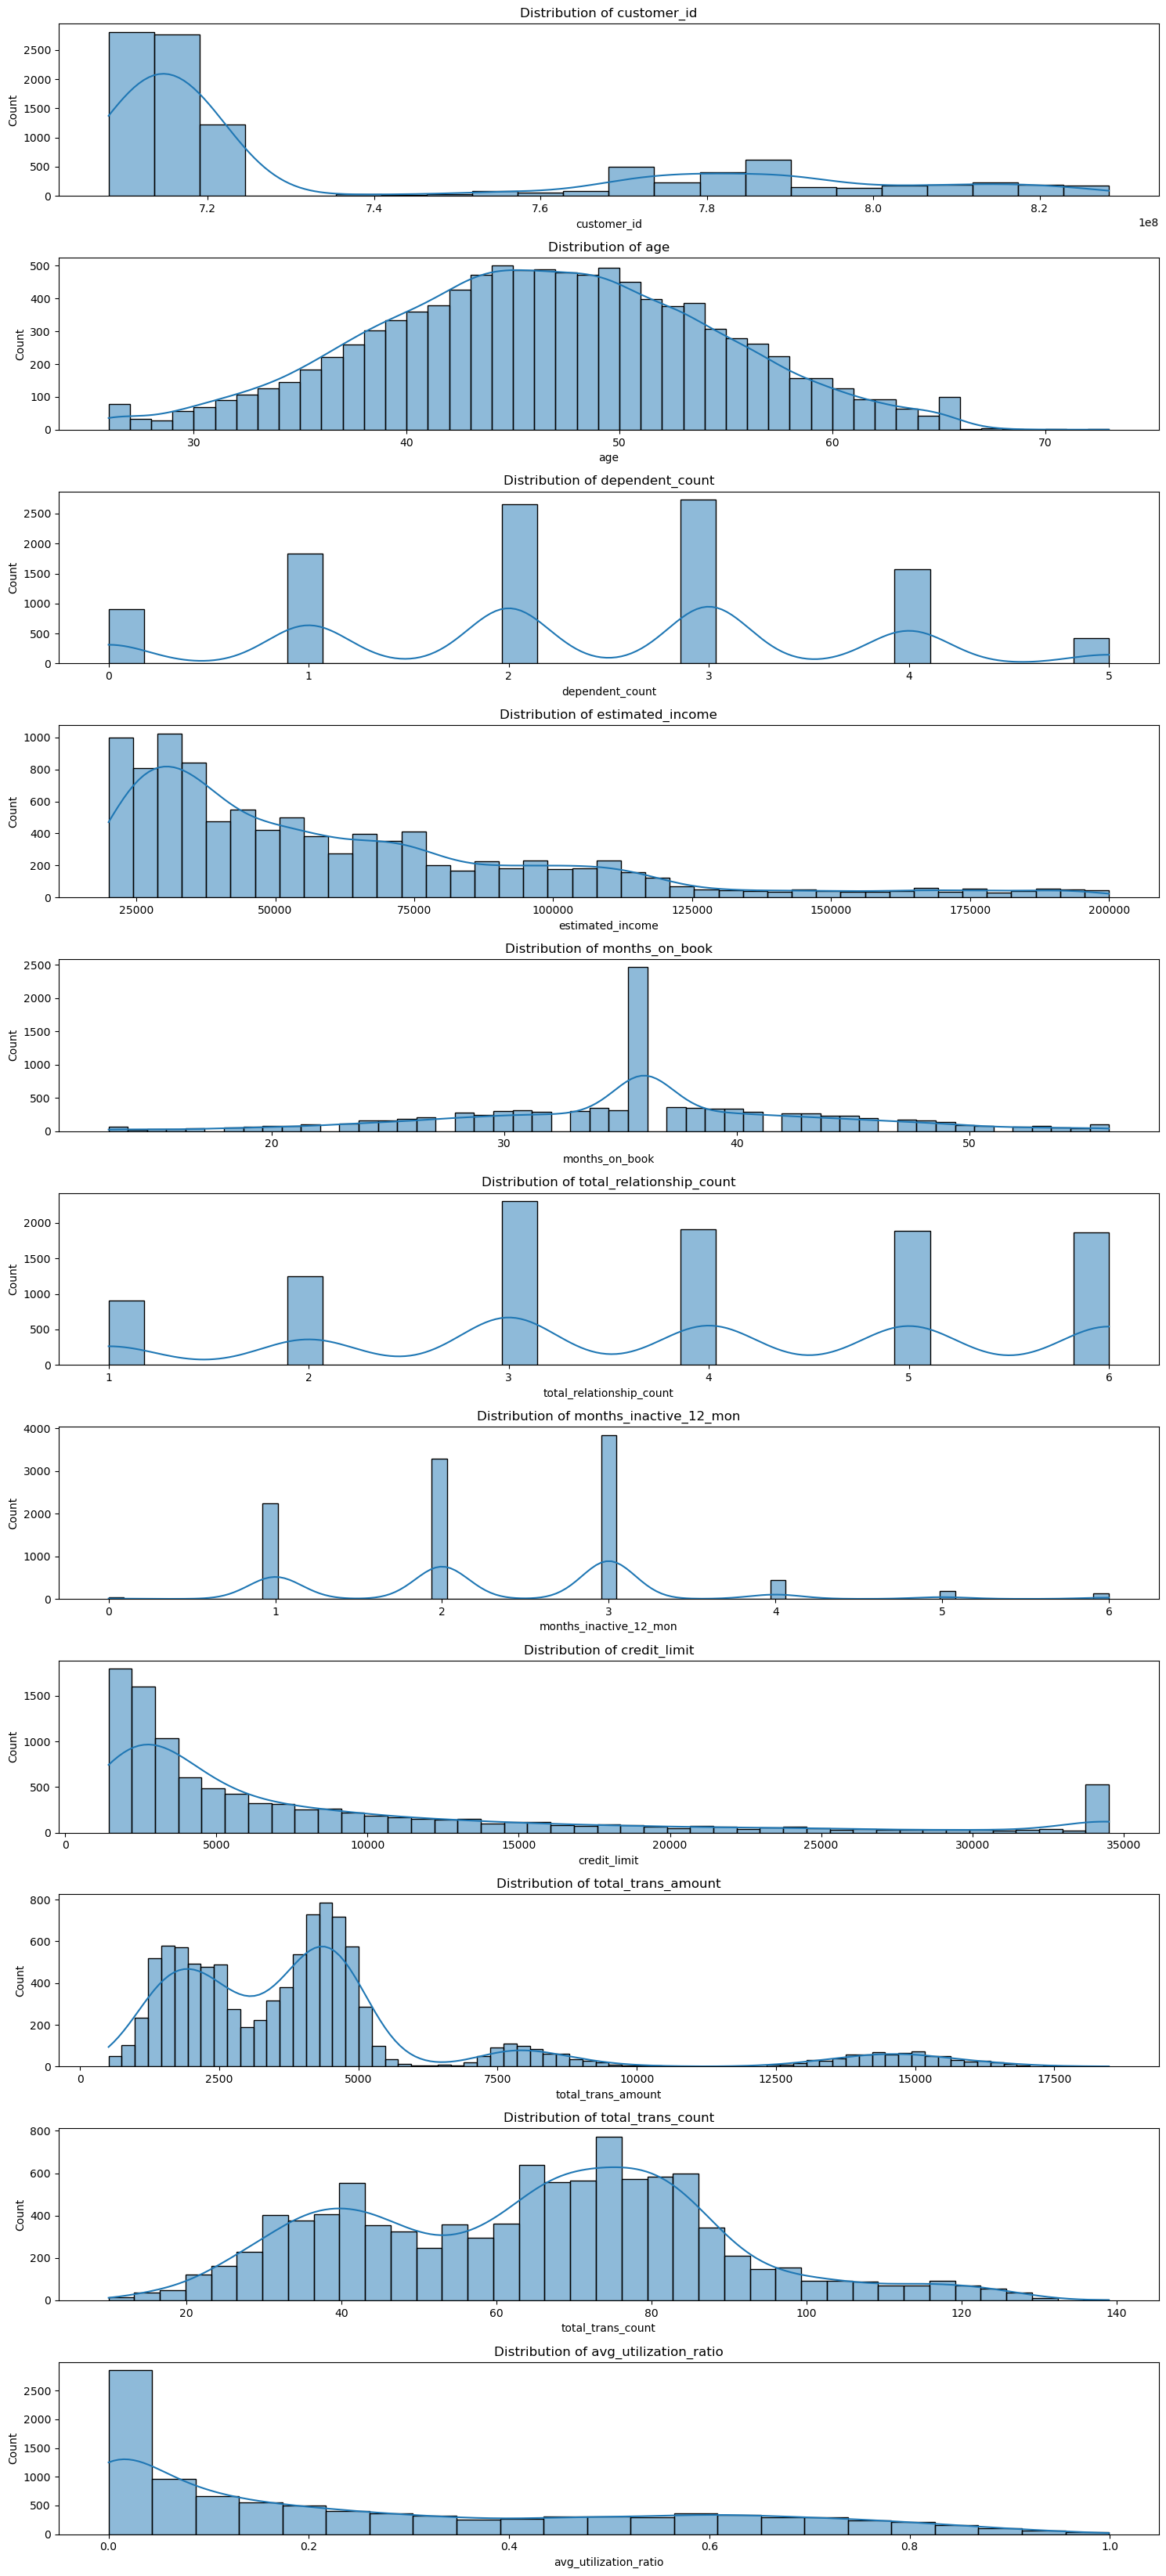

In [11]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, len(numeric_cols) * 3))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Correlation Matrix Analysis

The correlation matrix provides insights into the linear relationships between numerical features in the dataset. Below are the key findings:

---

#### Strong Positive Correlations

**`total_trans_amount` vs `total_trans_count` (r = 0.81):**
  - Customers who make more transactions also tend to spend more overall.
  - These features are highly related and may be redundant in linear models.

**`age` vs `months_on_book` (r = 0.79):**
  - Older customers tend to have a longer relationship with the company, suggesting loyalty increases with age.

**`estimated_income` vs `credit_limit` (r = 0.52):**
  - Customers with higher estimated income are generally assigned higher credit limits.
  - This correlation aligns with credit risk policies.

---

#### Moderate to Weak Negative Correlations

**`credit_limit` vs `avg_utilization_ratio` (r = -0.48):**
  - Customers with higher credit limits tend to use a smaller percentage of their available credit.
  - This may indicate healthier financial behavior.

**`total_relationship_count` vs `total_trans_amount` (r = -0.35):**
  - A higher number of product relationships does not necessarily lead to higher spending.
  - This might reflect customers spreading activity across different products.

---

#### Low or No Correlation (|r| < 0.3)

- Variables like `dependent_count`, `months_inactive_12_mon`, and `customer_id` show weak or no linear correlation with other features.
- These may still be useful in non-linear models but contribute little to linear relationships.

---

In [13]:
customer_modif = df.copy()

In [14]:
customer_modif["gender_male"] = customer_modif["gender"].apply(lambda x: 1 if x == "M" else 0)

In [15]:
education_level_map = {
    "Uneducated": 0,
    "High School": 1,
    "College": 2,
    "Graduate": 3,
    "Post-Graduate": 4,
    "Doctorate": 5
}

customer_modif["education_level"] = customer_modif["education_level"].replace(education_level_map)

/var/folders/xk/nv77f25j48v77gl3w9ysphq40000gn/T/ipykernel_9757/34811067.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_modif["education_level"] = customer_modif["education_level"].replace(education_level_map)


In [16]:
marital_dummies = pd.get_dummies(customer_modif["marital_status"], prefix="marital", dtype=int)
customer_modif = pd.concat([customer_modif, marital_dummies], axis=1)
customer_modif.drop(["marital_status", "gender"], axis=1, inplace=True)

In [17]:
customer_modif.head()

,customer_id,age,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,gender_male,marital_Divorced,marital_Married,marital_Single,marital_Unknown
0,768805383,45,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,1,0,0
1,818770008,49,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,0,0,1,0
2,713982108,51,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,1,0,0
3,769911858,40,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,0,0,1
4,709106358,40,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,1,0,0


In [18]:
df_features = customer_modif.drop(columns=["customer_id"])

scale_cols = [
    "age", "dependent_count", "education_level", "estimated_income", "months_on_book",
    "total_relationship_count", "months_inactive_12_mon", "credit_limit",
    "total_trans_amount", "total_trans_count", "avg_utilization_ratio"
]

non_scale_cols = [
    "gender_male", "marital_Divorced", "marital_Married",
    "marital_Single", "marital_Unknown"
]

scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_features[scale_cols])
scaled_df = pd.DataFrame(scaled_array, columns=scale_cols, index=df_features.index)

final_df = pd.concat([scaled_df, df_features[non_scale_cols]], axis=1)

In [19]:
final_df.head()

,age,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,gender_male,marital_Divorced,marital_Married,marital_Single,marital_Unknown
0,-0.165406,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1,0,1,0,0
1,0.333570,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,0,0,0,1,0
2,0.583058,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1,0,1,0,0
3,-0.789126,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,0,0,0,0,1
4,-0.789126,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1,0,1,0,0


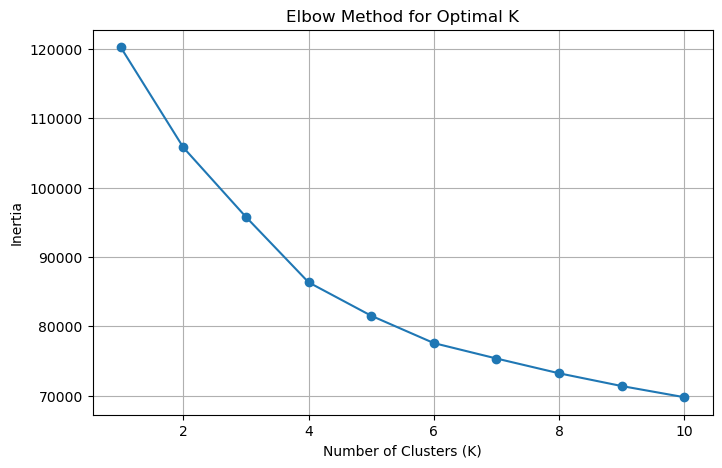

In [20]:
model_inertias = []
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(final_df)
    model_inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, model_inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [21]:
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(final_df)

print("Cluster assignments for each customer:")
print(cluster_labels)

Cluster assignments for each customer:
[1 1 1 ... 1 5 5]


In [22]:
final_df["CLUSTER"] = cluster_labels + 1

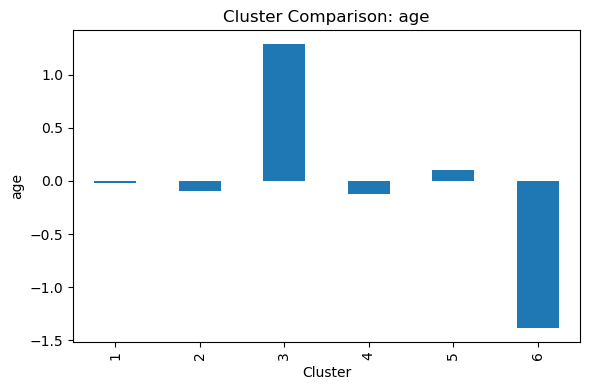

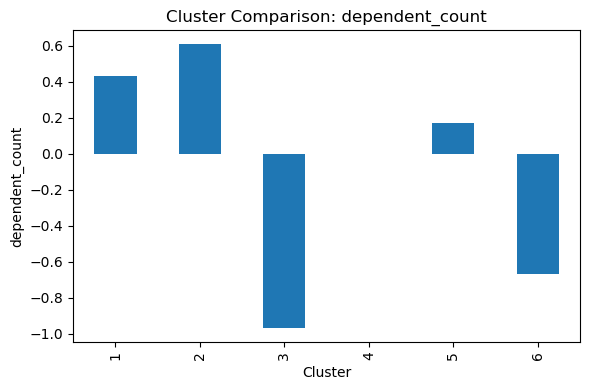

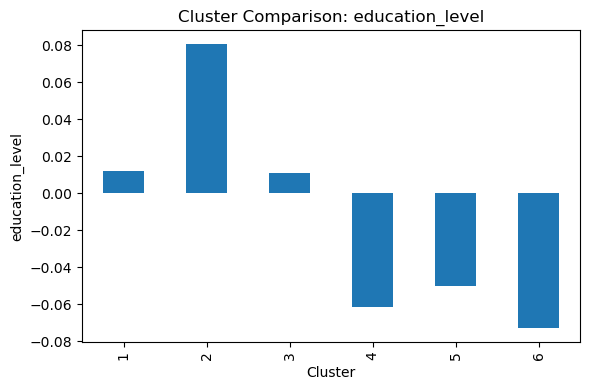

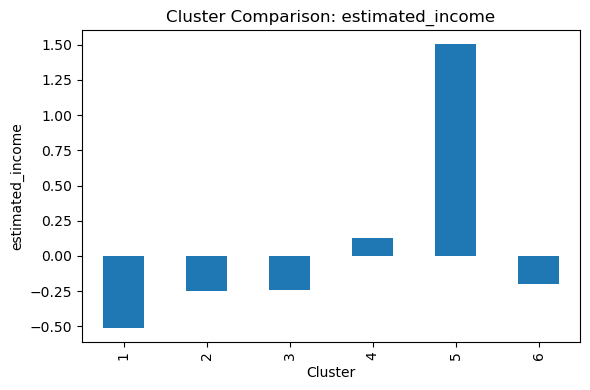

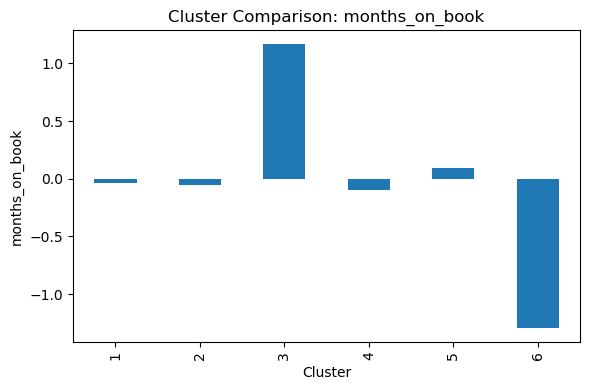

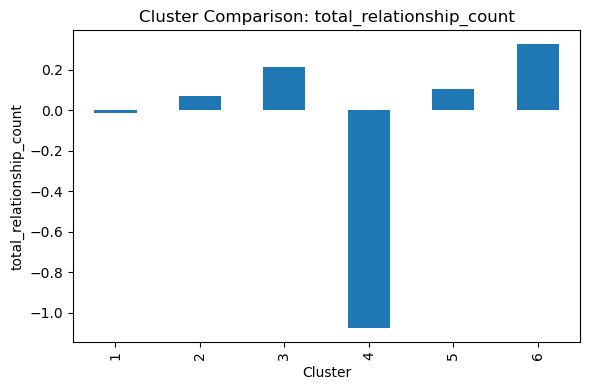

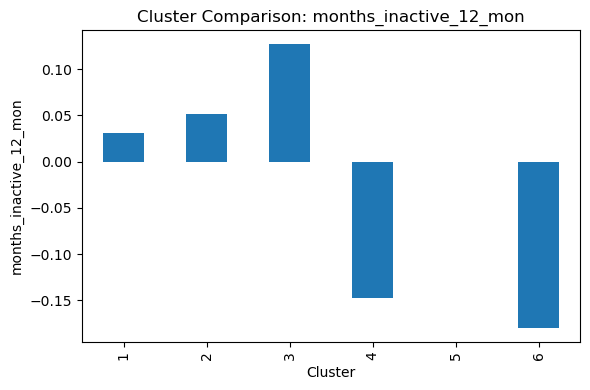

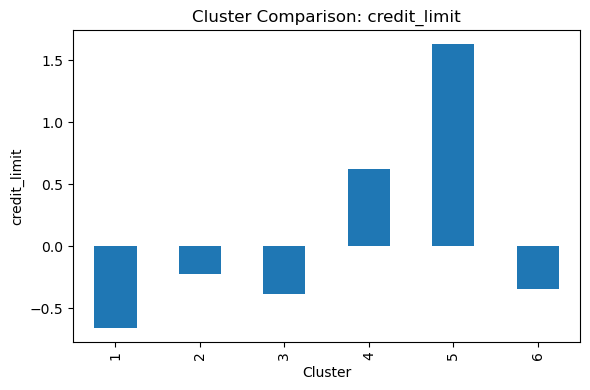

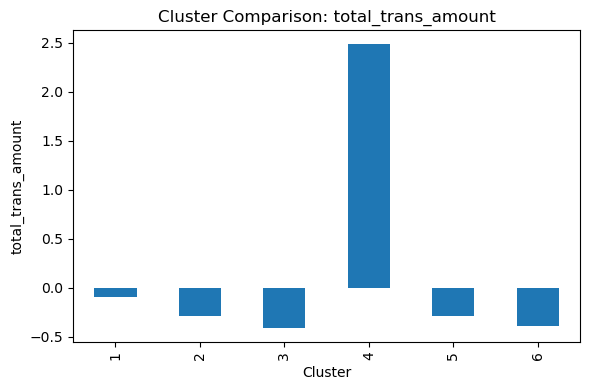

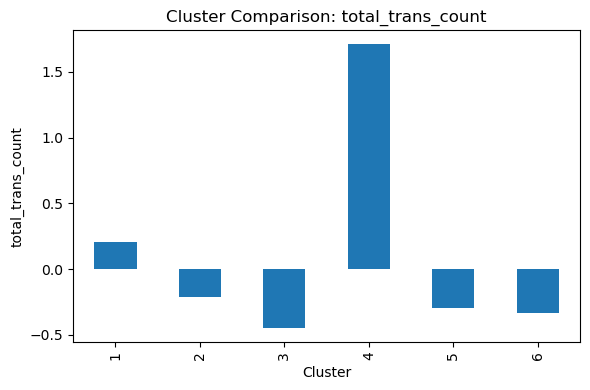

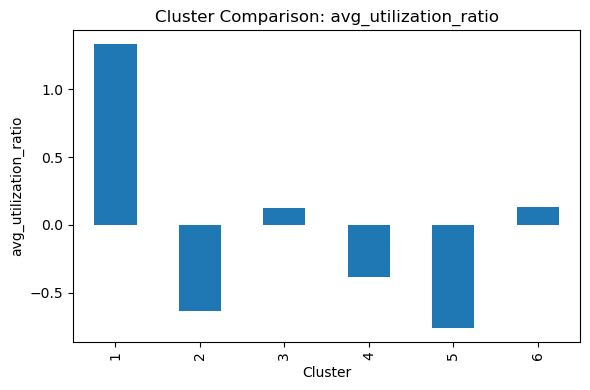

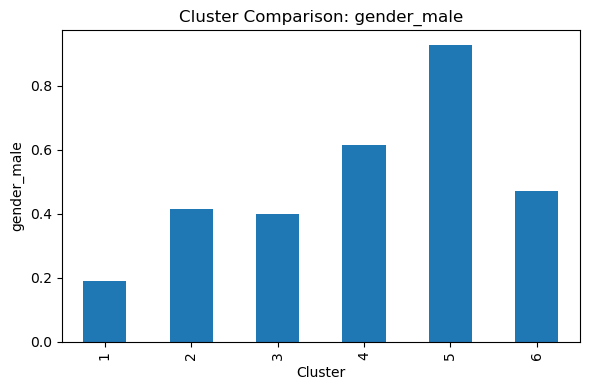

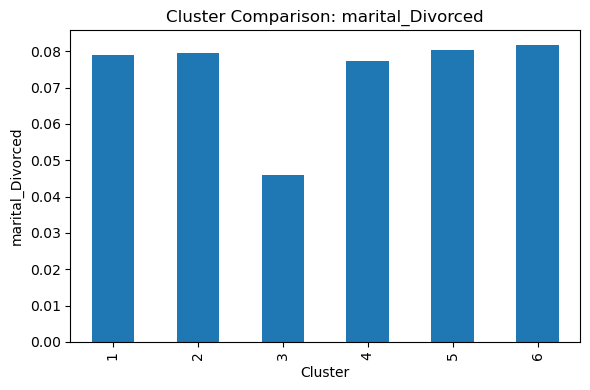

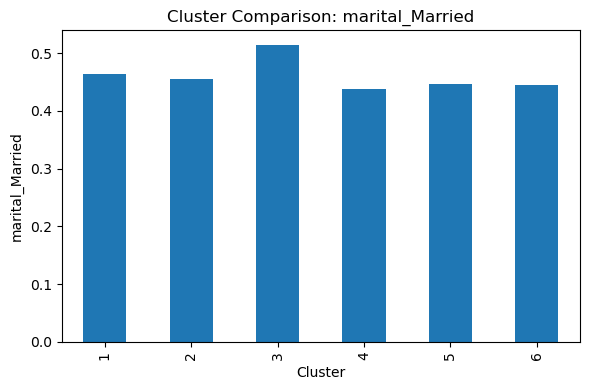

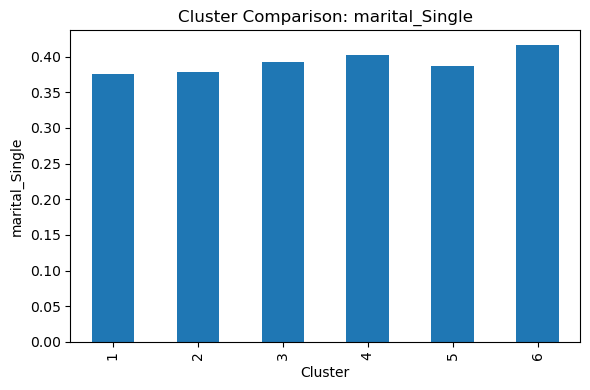

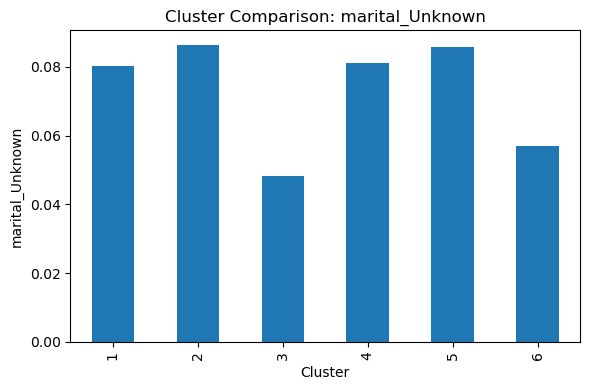

In [23]:
numeric_cols = final_df.drop(columns="CLUSTER").select_dtypes(include="number").columns

cluster_means = final_df.groupby("CLUSTER")[numeric_cols].mean()

for col in numeric_cols:
    cluster_means[col].plot(kind="bar", figsize=(6,4), title=f"Cluster Comparison: {col}", legend=False)
    plt.ylabel(col)
    plt.xlabel("Cluster")
    plt.tight_layout()
    plt.show()

In [24]:
corr_matrix = final_df.drop(columns="CLUSTER").corr()

high_corr_pairs = corr_matrix.where(
    (corr_matrix.abs() > 0.7) & (corr_matrix.abs() < 1.0)
).stack().sort_values(ascending=False)

print("Highly correlated pairs:\n", high_corr_pairs)

Highly correlated pairs:
 total_trans_amount  total_trans_count     0.807192
total_trans_count   total_trans_amount    0.807192
age                 months_on_book        0.788912
months_on_book      age                   0.788912
marital_Married     marital_Single       -0.741185
marital_Single      marital_Married      -0.741185
dtype: float64


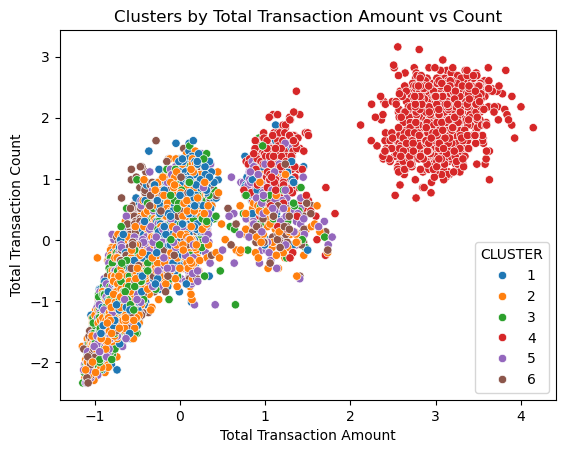

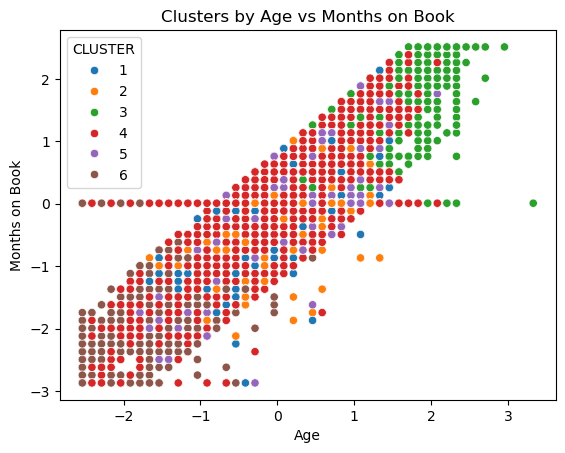

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=final_df,
    x="total_trans_amount",
    y="total_trans_count",
    hue="CLUSTER",
    palette="tab10"
)
plt.title("Clusters by Total Transaction Amount vs Count")
plt.xlabel("Total Transaction Amount")
plt.ylabel("Total Transaction Count")
plt.show()

sns.scatterplot(
    data=final_df,
    x="age",
    y="months_on_book",
    hue="CLUSTER",
    palette="tab10"
)
plt.title("Clusters by Age vs Months on Book")
plt.xlabel("Age")
plt.ylabel("Months on Book")
plt.show()

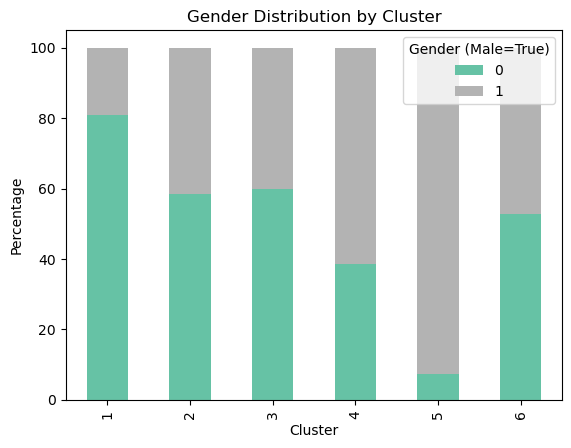

In [26]:
gender_ct = pd.crosstab(final_df["CLUSTER"], final_df["gender_male"], normalize='index') * 100
gender_ct.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Gender Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.legend(title="Gender (Male=True)")
plt.show()

In [27]:
def get_marital_status(row):
    for col in ['marital_Divorced', 'marital_Married', 'marital_Single', 'marital_Unknown']:
        if row[col] == 1:
            return col.replace("marital_", "")
    return "Unknown"

final_df["marital_status"] = final_df.apply(get_marital_status, axis=1)

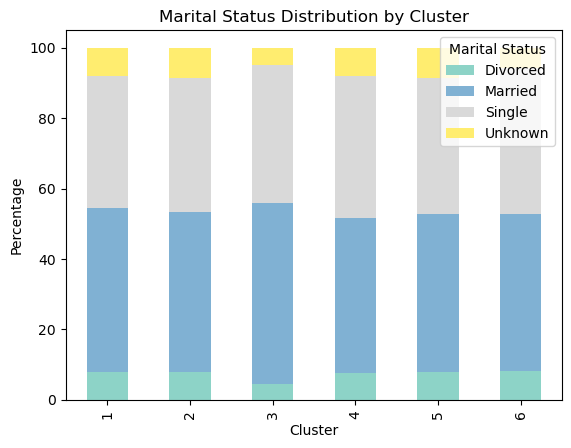

In [28]:
marital_ct = pd.crosstab(final_df["CLUSTER"], final_df["marital_status"], normalize='index') * 100
marital_ct.plot(kind="bar", stacked=True, colormap="Set3")
plt.title("Marital Status Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.legend(title="Marital Status")
plt.show()

# Customer Segmentation Insights

This analysis uses K-Means clustering to segment credit card customers into distinct behavioral groups. The goal is to better understand customer needs and identify opportunities for growth, retention, or risk mitigation.

## Clustering Overview

- **Method**: K-Means Clustering
- **Optimal clusters**: 6 (selected using the Elbow Method)
- **Features used**: Total transaction amount, count, credit limit, utilization ratio, age, tenure, etc.

---

## Cluster Summary & Strategic Insights

| Cluster | Label                 | Key Characteristics                                                                 | Suggested Strategy                                                  |
|--------:|-----------------------|--------------------------------------------------------------------------------------|----------------------------------------------------------------------|
| 0       | 🟩 **High Rollers**     | 🔹 High transaction amount & count<br>🔹 High credit limit<br>🔹 Low utilization       | Offering premium cards or loyalty perks<br> Upselling luxury benefits  |
| 1       | 🟦 **Steady Spenders** | 🔹 Medium-to-high spenders<br>🔹 Moderate credit use<br>🔹 Long tenure, loyal          | Strengthening with retention offers<br> Providing milestone bonuses  |
| 2       | 🟨 **Dormant Users**    | 🔹 Low transactions<br>🔹 Low credit usage<br>🔹 Often younger clients or new members   | Engaging with usage incentives<br> Onboarding with tips and campaigns |
| 3       | 🟥 **Credit Risk Zone** | 🔹 High utilization ratio<br>🔹 Low-to-medium credit limits<br>🔹 Possibly overextended | Monitoring closely<br> Offer credit counseling / alerts             |
| 4       | 🟧 **Young Achievers**  | 🔹 Moderate spending<br>🔹 Newer customers<br>🔹 Likely young and growing               | Cross-sell lifestyle perks<br> Using digital-first engagement     |
| 5       | 🟪 **Underutilized Elite** | 🔹 High credit limit<br>🔹 Low utilization<br>🔹 High income, low spending            | Proposing investment or travel rewards<br> Personalized attention  |

---

## Visual Interpretation Highlights

- **Total Transaction Plots**:
    - Cluster 0 (High Rollers) is clustered in the top-right: frequent and high spenders.
    - Cluster 2 & 5 are in low-frequency zones with different credit profiles.
      
  
- **Utilization vs. Limit**:
    - Cluster 3 exhibits risky behavior (high usage on limited credit).
    - Cluster 5 uses very little of their high credit limit — safe but underutilized.


- **Age vs. Tenure**:
    - Older customers tend to have longer tenures (Clusters 1, 0).
    - Cluster 4 is younger and newer — great opportunity for relationship building.


- **Demographics**:
    - Stacked bar charts suggest:
        - Gender/marital patterns vary — Cluster 4 has more singles, Cluster 1 more married users.
        - Useful for tailoring communication styles.

---

## Business Recommendations

1. **Loyalty Programs**: Rewarding Clusters 0 and 1 with VIP experiences and point multipliers.
2. **Activation Campaigns**: Nurturing Clusters 2 and 4 with cashback offers or auto-pay benefits.
3. **Risk Management**: Watching Cluster 3; setting credit alerts or soft limits.
4. **Upsell & Cross-sell**: Introducing Cluster 5 to premium investment or travel-linked cards.
